In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU type
!nvidia-smi

Sun Oct 20 05:35:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
pip install --upgrade opencv-python

In [4]:
# Install ultralytics
!pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 19.3 MB/s eta 0:00:00


In [5]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Path to where your data is stored
DATA_DIR = Path('')

# Preview data files available
os.listdir(DATA_DIR)

['.config', 'drive', 'sample_data']

In [7]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [8]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR / '/content/drive/Othercomputers/My PC/Projects/Challenge-Repository/ghana_crop_disease_detection_challenge/images.zip', 'images')

In [9]:
# Load train and test files
train = pd.read_csv(DATA_DIR / '/content/drive/Othercomputers/My PC/Projects/Challenge-Repository/ghana_crop_disease_detection_challenge/Train.csv')
test = pd.read_csv(DATA_DIR / '/content/drive/Othercomputers/My PC/Projects/Challenge-Repository/ghana_crop_disease_detection_challenge/Test.csv')
ss = pd.read_csv(DATA_DIR / '/content/drive/Othercomputers/My PC/Projects/Challenge-Repository/ghana_crop_disease_detection_challenge/SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax            image_path  class_id  
0   208.107730   341.967928  images/id_11543h.jpg         5  
1   162.910362   266.195724  images/id_11543h.jpg         5  
2   252.712993   338.876645  images/id_11543h.jpg         5  
3   238.593750   354.651316  images/id_11543h.jpg         5  
4  2184.252196  1401.748952  images/id_11ee1c.jpg         8

In [10]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images/id_128pxx.jpg  
1  images/id_12jbci.jpg  
2  images/id_143s4o.jpg  
3  images/id_14tfmb.jpg  
4  images/id_14tw4o.jpg

In [11]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [12]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [13]:
def empty_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# Check if dirs exist, if they do, empty them, otherwise create them.
for DIR in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_LABELS_DIR, TEST_LABELS_DIR]:
    if DIR.exists():
        empty_directory(DIR)
    else:
        DIR.mkdir(parents=True, exist_ok=True)

In [14]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [15]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax            image_path  class_id  
0   328.803454  208.107730   341.967928  images/id_11543h.jpg         5  
1   256.768914  162.910362   266.195724  images/id_11543h.jpg         5  
2   327.138158  252.712993   338.876645  images/id_11543h.jpg         5  
3   340.411184  238.593750   354.651316  images/id_11543h.jpg         5  
6  2735.933839  850.476742  2834.348725  images/id_11gglx.jpg         0

In [16]:
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations
def process_dataset(dataframe, output_dir):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use multiprocessing Pool to process tasks
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

100%|██████████| 1226/1226 [02:16<00:00,  8.98it/s]


In [17]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [18]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_nnaec7.jpg with 5 bounding boxes.


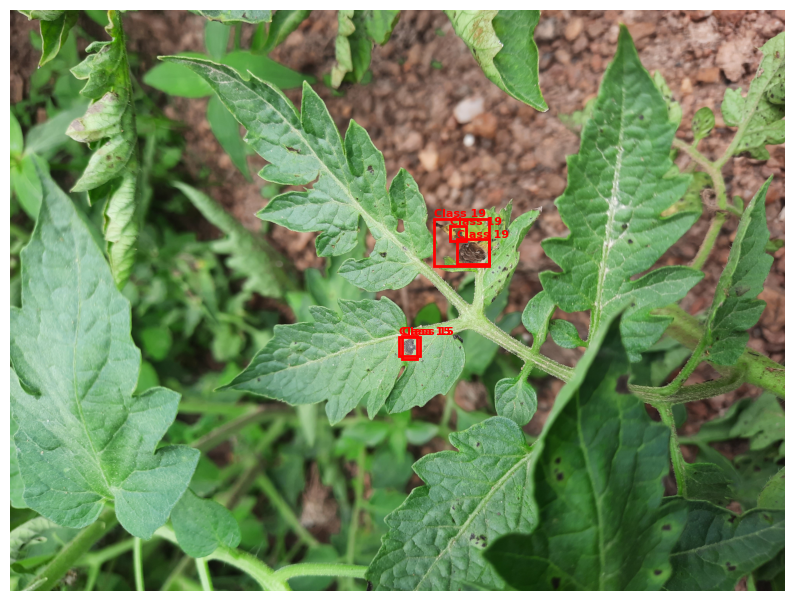

Plotting id_45wu2u.jpg with 20 bounding boxes.


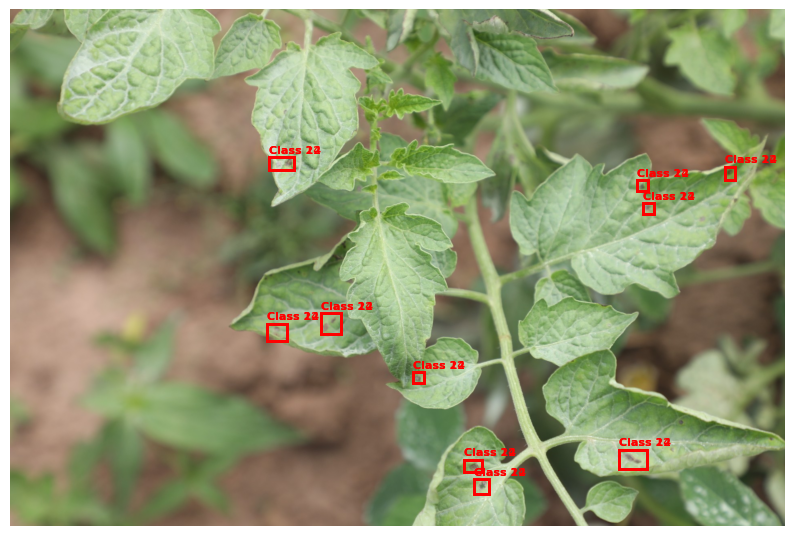

Plotting id_4slhnz.jpg with 6 bounding boxes.


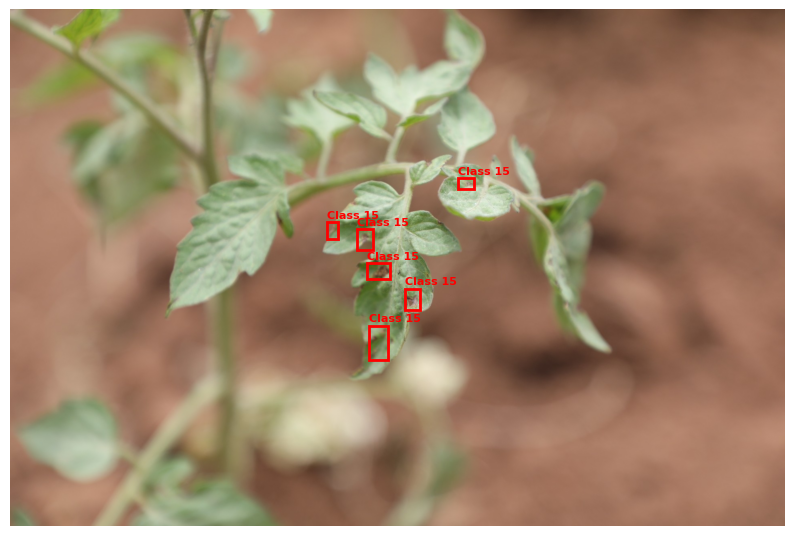

Plotting id_3u3nt8.jpg with 13 bounding boxes.


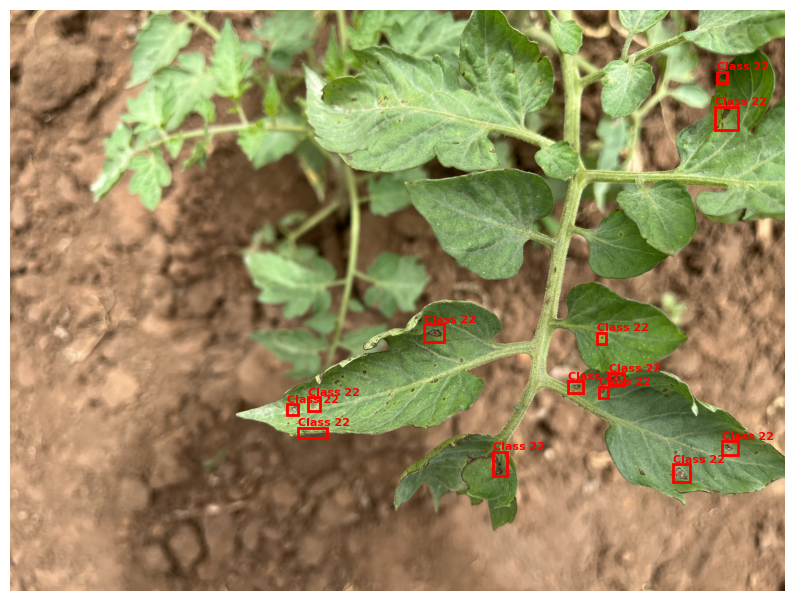

Plotting id_h8lnc5.jpg with 5 bounding boxes.


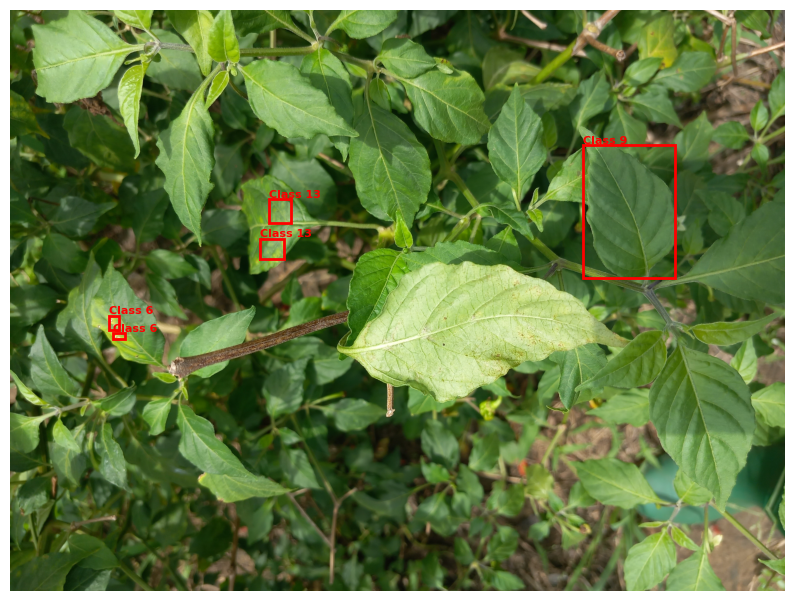

In [19]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pretrained model
model = YOLO('yolov10b.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=20,                 # Number of epochs
    imgsz=640,                # Image size (height, width)
    batch=8,                  # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)

100%|██████████| 39.7M/39.7M [00:00<00:00, 43.1MB/s]


Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10b.pt, data=data.yaml, epochs=20, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

100%|██████████| 755k/755k [00:00<00:00, 37.6MB/s]


Overriding model.yaml nc=80 with nc=23
WARNING ⚠️ no model scale passed. Assuming scale='b'.

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  4   1444864  ultralytics.nn.modules.block.C2f             [256, 256, 4, True]           
  5                  -1  1    137728  ultralytics.nn.modules.block.SCDown          [256, 512, 3, 2]              
  6                  -1  4   5773312  ultralytics.nn.modules.block.C2f             [512, 512, 4, True]      

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 149MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/labels/train... 3676 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3676/3676 [00:09<00:00, 406.39it/s]

train: New cache created: /content/datasets/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/dataset/labels/val... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:03<00:00, 366.08it/s]

val: New cache created: /content/datasets/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 135 weight(decay=0.0), 148 weight(decay=0.0005), 147 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.44G      4.717      7.756      3.326         72        640: 100%|██████████| 460/460 [06:32<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [01:32<00:00,  1.20s/it]


                   all       1226      10252      0.241      0.142     0.0722     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.21G      4.526      5.862      3.158         62        640: 100%|██████████| 460/460 [06:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [01:35<00:00,  1.24s/it]


                   all       1226      10252      0.395       0.17     0.0926     0.0366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.22G       4.58      5.637      3.126         73        640: 100%|██████████| 460/460 [06:26<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [01:32<00:00,  1.20s/it]


                   all       1226      10252      0.473      0.182      0.103      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.22G      4.525      5.442      3.117         72        640: 100%|██████████| 460/460 [06:26<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [01:33<00:00,  1.21s/it]


                   all       1226      10252      0.358       0.18      0.113      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.26G      4.496       5.41      3.087        139        640:  65%|██████▍   | 298/460 [04:11<01:43,  1.57it/s]

In [ ]:
# Validate the model on the validation set
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.val()

In [ ]:
# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/content/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary


    # Iterate through the results for this image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]  # Get the class name from the names dictionary

        # Add the result to the all_data list
        all_data.append({
            'Image_ID': image_file,
            'class': detected_class,
            'confidence': conf,
            'ymin': y1,
            'xmin': x1,
            'ymax': y2,
            'xmax': x2
        })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
#sub.to_csv('benchmark_submission.csv', index = False)